In [10]:
pip install yfinance

In [11]:
#Grab Data
import yfinance as yf

#Usual Suspects
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [12]:
aapl= yf.Ticker("aapl")
aapl

yfinance.Ticker object <AAPL>

In [16]:
# APPLE price levels for the past 10 years
symbol = 'AAPL'
raw = yf.download(symbol, start="2014-02-25", end="2024-02-26")['Adj Close']

data = pd.DataFrame(raw)

[*********************100%%**********************]  1 of 1 completed


In [17]:
data.head()

,Adj Close
Date,
2014-02-25,16.422804
2014-02-26,16.274639
2014-02-27,16.599281
2014-02-28,16.554293
2014-03-03,16.602112


In [18]:
#Calculate the returns and add it to the DataFrame
data['return'] = np.log(data['Adj Close'] / data['Adj Close'].shift(1))

#When the market direction is greater than 0 --> classify 1, less than 0 --> 0
data['direction'] = np.where(data['return'] > 0, 1, 0)

data.head()

,Adj Close,return,direction
Date,,,
2014-02-25,16.422804,NaN,0
2014-02-26,16.274639,-0.009063,0
2014-02-27,16.599281,0.019751,1
2014-02-28,16.554293,-0.002714,0
2014-03-03,16.602112,0.002884,1


In [19]:
#Create 5 columns for each lag representing previous day's return
lags = 5

cols = []
for lag in range(1, lags + 1):
  col = f'lag_{lag}'
  data[col] = data['return'].shift(lag)
  cols.append(col)

data.dropna(inplace=True)

In [20]:
data.round(4).tail()

,Adj Close,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,,,
2024-02-16,182.31,-0.0085,0,-0.0016,-0.0048,-0.0113,-0.0090,0.0041
2024-02-20,181.56,-0.0041,0,-0.0085,-0.0016,-0.0048,-0.0113,-0.0090
2024-02-21,182.32,0.0042,1,-0.0041,-0.0085,-0.0016,-0.0048,-0.0113
2024-02-22,184.37,0.0112,1,0.0042,-0.0041,-0.0085,-0.0016,-0.0048
2024-02-23,182.52,-0.0101,0,0.0112,0.0042,-0.0041,-0.0085,-0.0016


# Deep Neural Network Stuff

In [21]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, RMSprop
import random

In [22]:
optimizer = Adam(learning_rate=0.0001)

def set_seeds(seed=100):
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(100)

In [23]:
set_seeds()
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(lags,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [24]:
train_set, test_set = np.split(data, [int(.70 *len(data))])

In [25]:
mu, std = train_set.mean(), train_set.std()

In [26]:
# Normalizes the features data by Gaussian normalization
training_data_ = (train_set - mu) / std
test_data_ = (test_set - mu) / std

In [27]:
%%time
model.fit(train_set[cols],
           train_set['direction'],
           epochs=50, verbose=False,
           validation_split=0.2, shuffle=False)

Wall time: 8.61 s


In [28]:
res = pd.DataFrame(model.history.history)

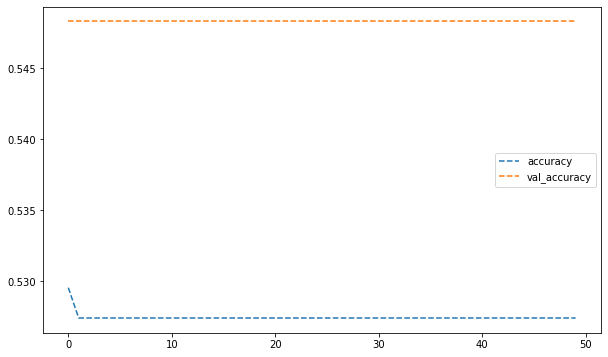

In [29]:
# Accuracy of the model for training and validation in the training set
res[['accuracy', 'val_accuracy']].plot(figsize=(10,6), style='--')

In [30]:
model.evaluate(training_data_[cols], train_set['direction'])

55/55 [==============================] - 0s 2ms/step - loss: 0.8220 - accuracy: 0.5367


[0.8219884634017944, 0.5367103219032288]

In [31]:
# Creating Prediction of market direction
pred = np.where(model.predict(training_data_[cols]) > 0.5, 1, 0)

55/55 [==============================] - 0s 2ms/step


In [32]:
pred

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [33]:
pred[:30].flatten()

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 1])

In [34]:
# Transforming the predictions to long-short position; 1,-1
train_set['prediction'] = np.where(pred > 0, 1, -1)

In [35]:
# Calculate strategy returns given the positions
train_set['strategy'] = (train_set['prediction'] * train_set['return'])

In [36]:
train_set[['return', 'strategy']].sum().apply(np.exp)

return       7.372220
strategy    12.040786
dtype: float64

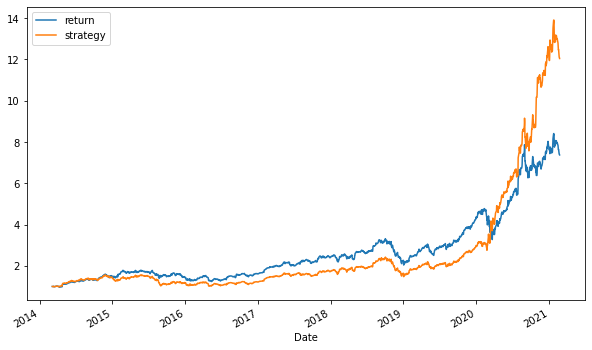

In [37]:
# Plots the strategy returns to the benchmark performance for the sample
train_set[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10,6))

# Same Process on the Out-of-Sample Test Set

In [38]:
model.evaluate(test_data_[cols], test_set['direction'])

24/24 [==============================] - 0s 2ms/step - loss: 0.8708 - accuracy: 0.5027


[0.8707950711250305, 0.5026525259017944]

In [39]:
pred = np.where(model.predict(test_data_[cols]) > 0.5, 1, 0)

24/24 [==============================] - 0s 2ms/step


In [40]:
test_set['prediction'] = np.where(pred > 0, 1, -1)

In [41]:
test_set['prediction'].value_counts()

 1    695
-1     59
Name: prediction, dtype: int64

In [42]:
test_set['strategy'] = (test_set['prediction'] * test_set['return'])

In [43]:
test_set[['return', 'strategy']].sum().apply(np.exp)

return      1.481476
strategy    1.482127
dtype: float64

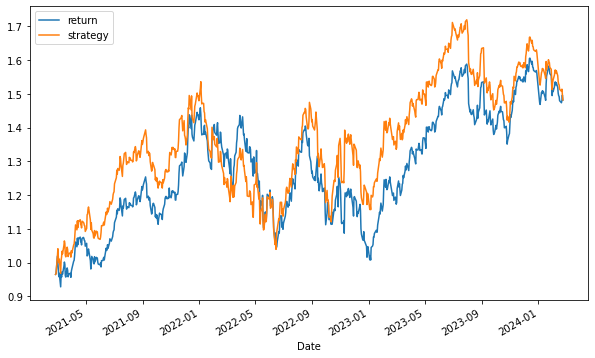

In [44]:
test_set[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10,6))

# Adding More Features

In [45]:
#Add momentum, volatitlity, & distance to the data_frame
data['momentum'] = data['return'].rolling(5).mean().shift(1)
data['volatility'] = data['return'].rolling(20).std().shift(1)
data['distance'] = (data['Adj Close'] - data['Adj Close'].rolling(50).mean()).shift(1)

In [46]:
data.dropna(inplace=True)

In [47]:
cols.extend(['momentum', 'volatility', 'distance'])

In [48]:
# New DataFrame
data.round(4).tail()

,Adj Close,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5,momentum,volatility,distance
Date,,,,,,,,,,,
2024-02-16,182.31,-0.0085,0,-0.0016,-0.0048,-0.0113,-0.0090,0.0041,-0.0045,0.0101,-6.0050
2024-02-20,181.56,-0.0041,0,-0.0085,-0.0016,-0.0048,-0.0113,-0.0090,-0.0070,0.0094,-7.3378
2024-02-21,182.32,0.0042,1,-0.0041,-0.0085,-0.0016,-0.0048,-0.0113,-0.0061,0.0088,-7.8775
2024-02-22,184.37,0.0112,1,0.0042,-0.0041,-0.0085,-0.0016,-0.0048,-0.0030,0.0086,-6.8834
2024-02-23,182.52,-0.0101,0,0.0112,0.0042,-0.0041,-0.0085,-0.0016,0.0002,0.0092,-4.6116


In [49]:
# Refit and train/test
train_data, test_data = np.split(data, [int(.70 *len(data))])
mu, std = train_data.mean(), train_data.std()

In [50]:
training_data_ = (train_data - mu) / std
test_data_ = (test_data - mu) / std

In [51]:
# Update Dense Layers to 32
set_seeds()
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(len(cols),)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [52]:
%%time
model.fit(training_data_[cols],
           train_data['direction'],
           epochs=25, verbose=False,
           validation_split=0.2, shuffle=False)

Wall time: 4.53 s


In [53]:
model.evaluate(training_data_[cols], train_data['direction'])

54/54 [==============================] - 0s 2ms/step - loss: 0.6924 - accuracy: 0.5505


[0.692440390586853, 0.5505226254463196]

In [54]:
pred = np.where(model.predict(training_data_[cols]) > 0.5, 1, 0)

54/54 [==============================] - 0s 2ms/step


In [55]:
train_data['prediction'] = np.where(pred > 0, 1, -1)

In [56]:
train_data['strategy'] = (train_data['prediction'] * train_data['return'])

In [57]:
train_data[['return', 'strategy']].sum().apply(np.exp)

return      6.527244
strategy    8.337237
dtype: float64

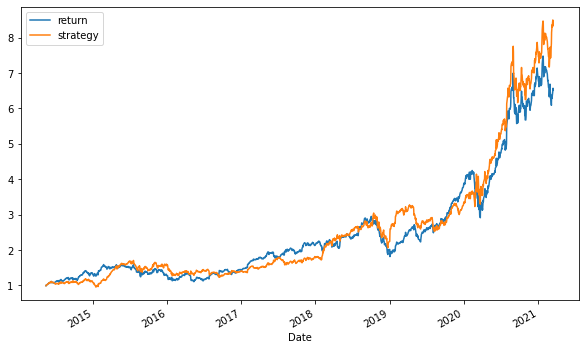

In [58]:
train_data[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10,6))

With additional features we see significantly better results, but let's test it against the out-of-sample test set

## Test Set Prediction

In [59]:
model.evaluate(test_data_[cols], test_data['direction'])

24/24 [==============================] - 0s 2ms/step - loss: 0.7255 - accuracy: 0.5129


[0.7254523634910583, 0.5128552317619324]

In [60]:
pred = np.where(model.predict(test_data_[cols]) > 0.5, 1, 0)

24/24 [==============================] - 0s 2ms/step


In [61]:
test_data['prediction'] = np.where(pred > 0, 1, -1)

In [62]:
test_set['prediction'].value_counts()

 1    695
-1     59
Name: prediction, dtype: int64

In [63]:
test_set['strategy'] = (test_set['prediction'] * test_set['return'])

In [64]:
test_set[['return', 'strategy']].sum().apply(np.exp)

return      1.481476
strategy    1.482127
dtype: float64

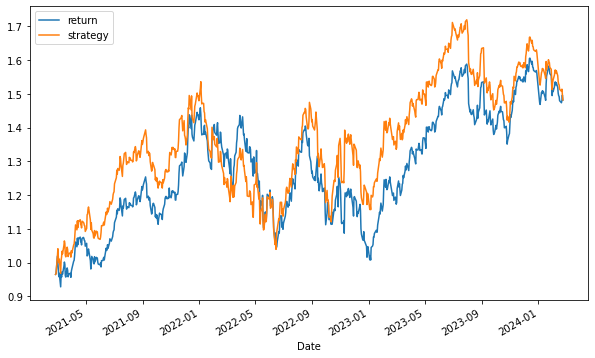

In [65]:
test_set[['return', 'strategy']].cumsum().apply(np.exp).plot(figsize=(10,6))